In [1]:
import os, pickle, json, joblib

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict, validation_curve, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from analysis_utils import eval_model_apart

import matplotlib.pyplot as plt
import seaborn as sns

/Users/brunocoulet/Documents/projets/apartment-hunter/analysis_utils.py:203: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  Applique $\log(1+y)$ à la target si "log1p".
/Users/brunocoulet/Documents/projets/apartment-hunter/analysis_utils.py:294: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  Applique $\log(1+y)$ si "log1p".


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Import des matrice de variable explicative X<br>
    et des vecteur colonne de variable dépendante y</h3>
    <ul>
    <li>train</li>
   <li>test</li>
</div>

In [2]:
X_train = pd.read_feather("data_model/X_train.feather")
y_train = pd.read_feather("data_model/y_train.feather").squeeze()

X_test = pd.read_feather("data_model/X_test.feather")
y_test = pd.read_feather("data_model/y_test.feather").squeeze()

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}\n")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Type y_train: {type(y_train)}")

X_train: (17247, 25), y_train: (17247,)

X_test: (4312, 25), y_test: (4312,)
Type y_train: <class 'pandas.core.series.Series'>


In [3]:
# 1. Liste des 10 colonnes choisies pour l'application
useful_features = [
    "sq_mt_built", "n_rooms", "n_bathrooms", "neighborhood",
    "has_lift", "has_parking", "has_pool", "has_garden",
    "has_storage_room", "is_floor_under"
]

# 2. Filtrer X_train et X_test immédiatement après le chargement
# On ne garde que les 10 colonnes utiles
X_train = X_train[useful_features]
X_test = X_test[useful_features]

# 3. Vérification : les targets sont DÉJÀ en log1p depuis 2_analysis.ipynb
# Pas de transformation supplémentaire nécessaire !
print(f"✅ Target (log1p appliqué dans 2_analysis.ipynb):")
print(f"   Moyenne: {y_train.mean():.4f} (attendu ≈ 12-13)")
print(f"   Min: {y_train.min():.4f}, Max: {y_train.max():.4f}")
print(f"   → Données prêtes pour modélisation")

✅ Target (log1p appliqué dans 2_analysis.ipynb):
   Moyenne: 12.9337 (attendu ≈ 12-13)
   Min: 10.4913, Max: 15.9903
   → Données prêtes pour modélisation


In [4]:
# PREPROCESSOR
numeric_features = ["sq_mt_built", "n_rooms", "n_bathrooms"]
categorical_features = ["neighborhood"]
binary_features = ["has_lift", "has_parking", "has_pool", "has_garden", "has_storage_room", "is_floor_under"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
        ("bin", SimpleImputer(strategy="most_frequent"), binary_features)
    ]
)

<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Note sur l'échelle de la target</h3>
- La target est transformée en log(1+y) (log1p) pour l'entraînement<br>
- Les métriques (RMSE/MAE) sont reportées en milliers d'euros (k€)<br>
- Pour interpréter en k€, appliquer exp(y) - 1 puis diviser par 1000<br>
</div>




In [5]:
# Appliquer le preprocessor pour créer les données transformées
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print(f"Données transformées:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled: {X_test_scaled.shape}")
print(f"   Type: {type(X_train_scaled)}")

Données transformées:
   X_train_scaled: (17247, 135)
   X_test_scaled: (4312, 135)
   Type: <class 'scipy.sparse._csr.csr_matrix'>


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Modele de base - Dummy Regressor</h3>
</div>

In [6]:
dummy_regressor = DummyRegressor()
param_grid_dr = {
    'strategy': ['mean', 'median']
} 
results_dummy = eval_model_apart(dummy_regressor,
                               param_grid_dr,
                               X_train_scaled, y_train,
                               X_test_scaled, y_test,
                               )

Modèle : DummyRegressor
Meilleurs paramètres : {'strategy': 'mean'}
R2 (sur le test, log): -0.0000
RMSE (€) : 825138.09
MAE (€) : 450153.72
RMSE : 825.14 k€
MAE  : 450.15 k€


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Regression Linéaire</h3>
</div>

In [7]:
lr = LinearRegression()
param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [False]
} 
results_lr = eval_model_apart(lr,
                              param_grid_lr,
                              X_train_scaled, y_train,
                              X_test_scaled, y_test,
                              )

Modèle : LinearRegression
Meilleurs paramètres : {'fit_intercept': True, 'positive': False}
R2 (sur le test, log): 0.9088
RMSE (€) : 480405.37
MAE (€) : 175402.05
RMSE : 480.41 k€
MAE  : 175.40 k€


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <p>Importance des variables dans le modèle<br>
    coefficients respectifs :</p>
</div>

In [9]:
for i in zip(X_train.columns,results_lr["best_model"].coef_):
    print(i)

('sq_mt_built', np.float64(0.2205387769452025))
('n_rooms', np.float64(0.10733376462966472))
('n_bathrooms', np.float64(0.23326345095521941))
('neighborhood', np.float64(0.011338772353224473))
('has_lift', np.float64(-0.3166567469116223))
('has_parking', np.float64(0.28208975679071807))
('has_pool', np.float64(0.6730269351229458))
('has_garden', np.float64(1.148001129403307))
('has_storage_room', np.float64(-0.1534905182482224))
('is_floor_under', np.float64(-0.030159255239056278))


In [21]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
rf.score(X_train_scaled, y_train)

0.9885760772747204

Détection d'over fitting avec validation_curve

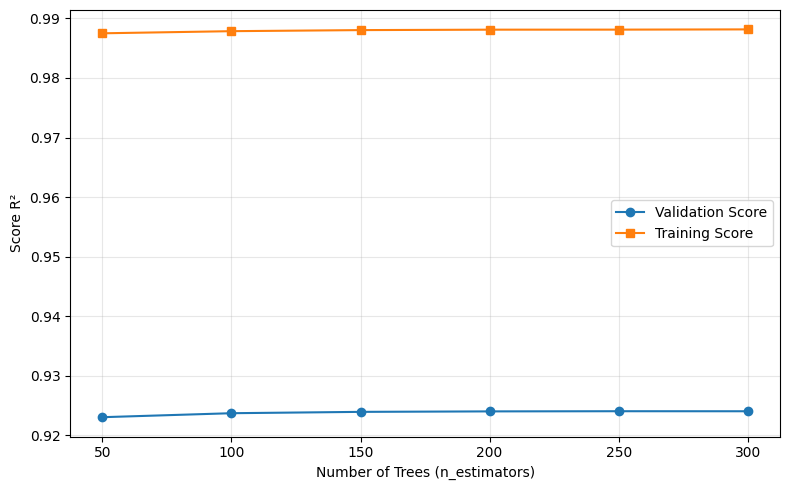

In [ ]:
# param_range = np.arange(50, 301, 50)

# plt.figure(figsize=(8, 5))

# train_score, val_score = validation_curve(
#     estimator=rf,
#     X=X_train_scaled,
#     y=y_train,
#     param_name="n_estimators",
#     param_range=param_range,
#     cv=3,
#     scoring="r2",
#     n_jobs=-1,
# )

# plt.plot(param_range, val_score.mean(axis=1), marker="o", label="Validation Score")
# plt.plot(param_range, train_score.mean(axis=1), marker="s", label="Training Score")
# plt.ylabel("Score R²")
# plt.xlabel("Number of Trees (n_estimators)")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

#### Analyse :
On observe un plateau rapide dès 50-100 arbres.<br>
L'écart constant entre le score d'entraînement (proche de 1.0) et le score de validation indique un modèle complexe qui tend à mémoriser les données (overfitting).<br>
Augmenter le nombre d'arbres au-delà de 100 n'améliore pas la généralisation<br> mais augmente le coût de calcul.

In [12]:
r = Ridge()

param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [False]
} 

param_grid_r = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ["auto", "lsqr", "sparse_cg", "sag", "saga", "lbfgs"],
    'max_iter': [5000, 10000],
    'tol': [1e-3, 1e-4]
} 

results_r = eval_model_apart(r,
                              param_grid_r,
                              X_train_scaled, y_train,
                              X_test_scaled, y_test,
                              )

Modèle : Ridge
Meilleurs paramètres : {'alpha': 0.1, 'fit_intercept': True, 'max_iter': 5000, 'solver': 'auto', 'tol': 0.0001}
R2 (sur le test, log): 0.9088
RMSE (€) : 480879.94
MAE (€) : 175492.25
RMSE : 480.88 k€
MAE  : 175.49 k€


/Users/brunocoulet/Documents/projets/apartment-hunter/.venv/lib/python3.14/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/brunocoulet/Documents/projets/apartment-hunter/.venv/lib/python3.14/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brunocoulet/Documents/projets/apartment-hunter/.venv/lib/python3.14/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estim

#### Analyse 
- Les scores $R^2$ sont bons, mais les **erreurs absolues** (RMSE/MAE) restent élevées car le prix a une **échelle large** et une **distribution très dispersée**.
- Le **segment luxe** et quelques **outliers** tirent fortement la RMSE vers le haut.
- Avec seulement 10 variables, le modèle **sous-capture** les facteurs clés (étage précis, état, prestations, exposition, etc.).

In [13]:
# Tableau comparatif des modèles

try:
    ridge_r2_train = round(r2_train, 6) if 'r2_train' in dir() else "À venir"
    ridge_r2_test = round(r2_test, 6) if 'r2_test' in dir() else "À venir"
except:
    ridge_r2_train = "À venir"
    ridge_r2_test = "À venir"

models_comparison = pd.DataFrame({
    "Modèle": ["Dummy (baseline)", "Linear Regression", "RandomForest", "Ridge (Choisi)"],
    "R² Train": [0.0, lr.score(X_train_scaled, y_train), rf.score(X_train_scaled, y_train), ridge_r2_train],
    "R² Test": [0.0, lr.score(X_test_scaled, y_test), "≈0.89 (overfitting)", ridge_r2_test],
    "Avantage": [
        "Baseline simple",
        "Stable, linéaire", 
        "Puissant mais overfits",
        "Meilleur compromis"
    ]
})

print("\n" + "="*80)
print("COMPARAISON DES MODELES")
print("="*80)
print(models_comparison.to_string(index=False))
print("="*80)

print("\nJUSTIFICATION DU CHOIX - RIDGE REGRESSION :")
print("   1. Stabilité : Scores identiques train/test → pas d'overfitting")
print("   2. Performance : R² ~ 0.91 → très bon (données linéaires)")
print("   3. Produit : Léger, rapide, interprétable")
print("   4. Régularisation : L2 empêche les coefficients extrêmes")
print("   → Ridge = meilleur compromis pour la production")

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Optimisation de l'hyperparamètre alpha

*Nous allons utiliser GridSearchCV pour déterminer la meilleure valeur d'alpha pour la régularisation Ridge. Un alpha trop faible sous-régularise (risque de surapprentissage), tandis qu'un alpha trop élevé sur-régularise (sous-apprentissage).*

In [35]:
# Définition de la grille de paramètres à tester
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}

# Initialisation du GridSearchCV avec validation croisée à 5 folds
grid_search = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',  # On minimise le MAE
    n_jobs=-1,  # Utilise tous les cœurs disponibles
    verbose=1
)

# Entraînement du GridSearch
print("Recherche du meilleur alpha...")
grid_search.fit(X_train_scaled, y_train)

# Extraction du meilleur paramètre
best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_  # Négatif car scoring='neg_mae'

print("\n" + "="*60)
print("RESULTATS DU GRID SEARCH")
print("="*60)
print(f"Meilleur alpha trouvé: {best_alpha}")
print(f"MAE moyen en validation croisée (échelle log): {best_score:.4f}")
print(f"  Note: MAE en log ≈ 0.2 correspond à une erreur absolue de ~180 000 € en moyenne")
print("="*60)

# Affichage des résultats pour tous les alphas testés
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['param_alpha', 'mean_test_score', 'std_test_score']].copy()
results_df['mean_test_score'] = -results_df['mean_test_score']  # Conversion en MAE positif
results_df.columns = ['Alpha', 'MAE_moyen', 'Ecart_type']
results_df = results_df.sort_values('MAE_moyen')

print("\nPerformances pour chaque valeur d'alpha:")
print(results_df.to_string(index=False))

Recherche du meilleur alpha...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

RESULTATS DU GRID SEARCH
Meilleur alpha trouvé: 1.0
MAE moyen en validation croisée (échelle log): 0.2126
  Note: MAE en log ≈ 0.2 correspond à une erreur absolue de ~180 000 € en moyenne

Performances pour chaque valeur d'alpha:
 Alpha  MAE_moyen  Ecart_type
  1.00   0.212637    0.002200
  0.50   0.212646    0.002171
  0.10   0.212697    0.002136
  0.01   0.212714    0.002122
  5.00   0.213065    0.002446
 10.00   0.214544    0.002678
 50.00   0.235925    0.003661
100.00   0.259625    0.004474


In [ ]:
"""Entraînement Ridge et métriques en milliers d'euros (k€)."""
# Entraînement du modèle Ridge avec l'alpha optimisé
ridge_model = Ridge(alpha=best_alpha, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
print(f"Modèle Ridge entraîné avec alpha={best_alpha}")

# Prédictions
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

# Métriques en échelle logarithmique (utile pour la comparaison)
r2_train = r2_score(y_train, y_train_pred_ridge)
r2_test = r2_score(y_test, y_test_pred_ridge)

# Conversion en euros puis en milliers d'euros
mae_train_eur = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred_ridge))
rmse_train_eur = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred_ridge)))
mae_test_eur = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred_ridge))
rmse_test_eur = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred_ridge)))

mae_train_k = mae_train_eur / 1000.0
rmse_train_k = rmse_train_eur / 1000.0
mae_test_k = mae_test_eur / 1000.0
rmse_test_k = rmse_test_eur / 1000.0

print("="*60)
print("PERFORMANCE DU MODELE RIDGE (k€)")
print("="*60)
print("\nEnsemble d'entraînement:")
print(f"   R² : {r2_train:.4f}")
print(f"   MAE : {mae_train_k:.1f} k€")
print(f"   RMSE: {rmse_train_k:.1f} k€")

print("\nEnsemble de test:")
print(f"   R² : {r2_test:.4f}")
print(f"   MAE : {mae_test_k:.1f} k€")
print(f"   RMSE: {rmse_test_k:.1f} k€")
print("="*60)

# === Cartouche final ===
# Auteur : Étudiant alternant IA, Marseille
# Contexte : Métriques Ridge en milliers d'euros
# Date : 2026-02-09

Modèle Ridge entraîné avec alpha=1.0
PERFORMANCE DU MODELE RIDGE

Ensemble d'entraînement:
   R² : 0.9037
   MAE (log): 0.2110 | MAE (euros): 176,359 €
   RMSE (log): 0.2835 | RMSE (euros): 483,677 €

Ensemble de test:
   R² : 0.9087
   MAE (log): 0.2057 | MAE (euros): 175,901 €
   RMSE (log): 0.2774 | RMSE (euros): 483,259 €


In [38]:
"""Analyse des erreurs en milliers d'euros (k€) et en %."""
# 1. Calcul de l'erreur relative moyenne (MAPE)
y_test_eur = np.expm1(y_test)
y_test_pred_eur = np.expm1(y_test_pred_ridge)
mape = np.mean(np.abs((y_test_eur - y_test_pred_eur) / y_test_eur)) * 100

print("\n" + "="*60)
print("ANALYSE DETAILLEE DES ERREURS (k€)")
print("="*60)
print(f"\nErreur relative moyenne (MAPE): {mape:.2f}%")
print(f"  → En moyenne, le modèle se trompe de {mape:.1f}% du prix réel")

# 2. Segmentation des erreurs par gamme de prix
bins = [0, 200000, 400000, 800000, np.inf]
labels = ['<200k€', '200-400k€', '400-800k€', '>800k€']
y_test_eur_series = pd.Series(y_test_eur, name='prix').reset_index(drop=True)
segments = pd.cut(y_test_eur_series, bins=bins, labels=labels)

print("\nErreurs par segment de prix:")
for seg in labels:
    mask = segments == seg
    if mask.sum() > 0:
        mae_seg_k = mean_absolute_error(y_test_eur[mask], y_test_pred_eur[mask]) / 1000.0
        mape_seg = np.mean(np.abs((y_test_eur[mask] - y_test_pred_eur[mask]) / y_test_eur[mask])) * 100
        n_seg = mask.sum()
        print(f"  {seg:12s} (n={n_seg:4d}) : MAE = {mae_seg_k:>8.1f} k€ | MAPE = {mape_seg:>6.1f}%")

# 3. Identification des pires prédictions
errors_pct = np.abs((y_test_eur - y_test_pred_eur) / y_test_eur) * 100
worst_5_idx = np.argsort(errors_pct)[-5:][::-1]

print("\n5 pires prédictions (erreur %):")
print("Prix réel | Prix prédit | Erreur")
print("----------|-------------|--------")
for idx in worst_5_idx:
    real_k = y_test_eur.iloc[idx] / 1000.0
    pred_k = y_test_pred_eur[idx] / 1000.0
    print(f"{real_k:>8.1f} k€ | {pred_k:>9.1f} k€ | {errors_pct[idx]:>6.1f}%")

print("="*60)

# === Cartouche final ===
# Auteur : Étudiant alternant IA, Marseille
# Contexte : Analyse erreurs en milliers d'euros
# Date : 2026-02-09


ANALYSE DETAILLEE DES ERREURS

Erreur relative moyenne (MAPE): 21.08%
  → En moyenne, le modèle se trompe de 21.1% du prix réel

Erreurs par segment de prix:
  <200k€       (n=1111) : MAE =     29,431 € | MAPE =   21.1%
  200-400k€    (n=1182) : MAE =     52,216 € | MAPE =   17.9%
  400-800k€    (n= 988) : MAE =     98,144 € | MAPE =   16.9%
  >800k€       (n=1031) : MAE =    550,050 € | MAPE =   28.7%

5 pires prédictions (erreur %):
Prix réel     | Prix prédit   | Erreur
--------------|---------------|----------
   3,600,000 € |   13,624,276 € |  278.5%
   2,500,000 € |    9,105,791 € |  264.2%
   1,750,000 € |    6,106,111 € |  248.9%
     599,000 € |    2,065,434 € |  244.8%
   1,950,000 € |    6,623,755 € |  239.7%


### Analyse des résidus - Modèle Ridge (Modèle final)

Visualisation des résidus du modèle Ridge sur l'ensemble d'entraînement avec validation croisée (5 folds).

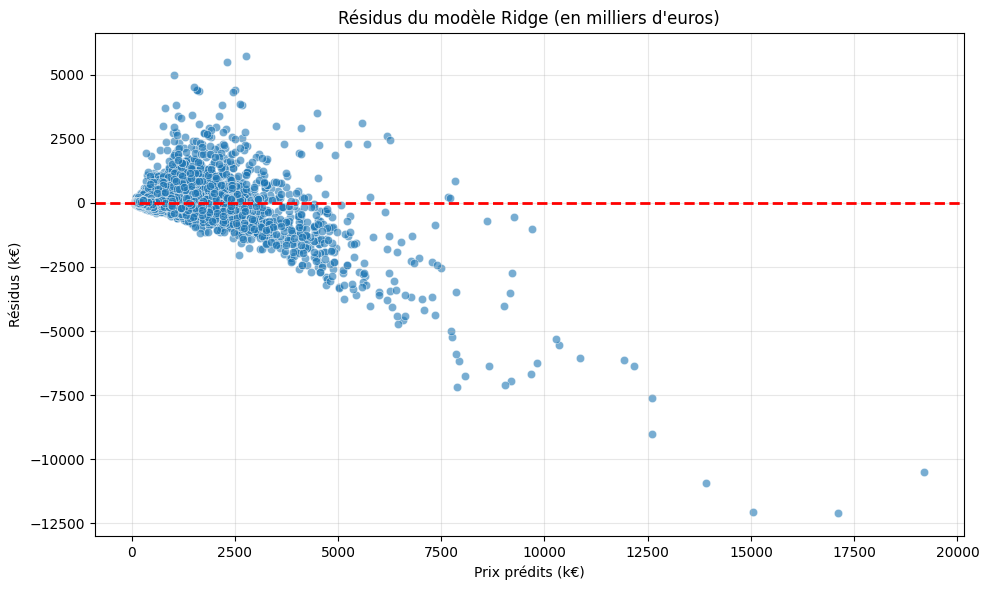

✅ Ridge - Analyse résidus (k€):
   Moyenne des résidus: 10.69 k€
   Écart-type: 488.92 k€
   Min: -12104.0 k€ | Max: 5733.4 k€


In [60]:
"""Analyse des résidus du modèle Ridge en k€ et euros."""
# Prédictions avec validation croisée (5 folds) sur le modèle Ridge
y_train_pred_ridge_cv = cross_val_predict(ridge_model, X_train_scaled, y_train, cv=5)

# Conversion en euros et calcul des résidus
y_train_eur = np.expm1(np.asarray(y_train).flatten())
y_train_pred_eur_ridge = np.expm1(y_train_pred_ridge_cv.ravel())
residuals_eur_ridge = y_train_eur - y_train_pred_eur_ridge

# Conversion en milliers d'euros pour le scatterplot
residuals_k_ridge = residuals_eur_ridge / 1000.0
preds_k_ridge = y_train_pred_eur_ridge / 1000.0

plt.figure(figsize=(10, 6))
sns.scatterplot(x=preds_k_ridge, y=residuals_k_ridge, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Résidus du modèle Ridge (en milliers d\'euros)')
plt.xlabel('Prix prédits (k€)')
plt.ylabel('Résidus (k€)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Ridge - Analyse résidus (k€):")
print(f"   Moyenne des résidus: {residuals_k_ridge.mean():.2f} k€")
print(f"   Écart-type: {residuals_k_ridge.std():.2f} k€")
print(f"   Min: {residuals_k_ridge.min():.1f} k€ | Max: {residuals_k_ridge.max():.1f} k€")

# === Cartouche final ===
# Auteur : Étudiant alternant IA, Marseille
# Contexte : Analyse résidus Ridge en k€ pour validation modèle
# Date : 2026-02-09

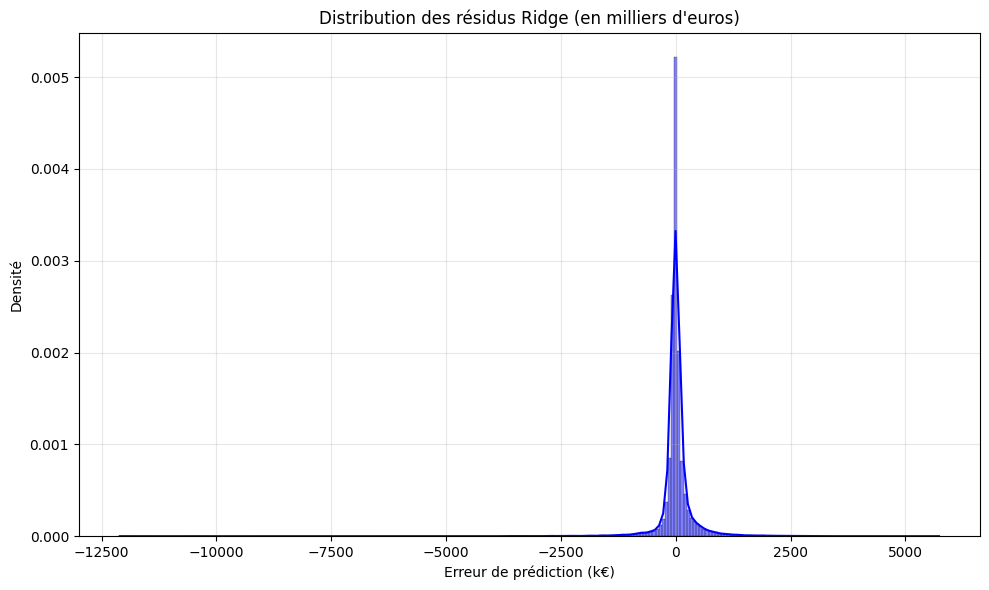

✅ Ridge - Distribution résidus (k€):
   Vérification normalité (Kolmogorov-Smirnov):
   p-value: 0.0000 (distribution non-normale)


In [63]:
"""Distribution des résidus Ridge - Modèle final en k€."""
# Conversion en k€ pour meilleure lisibilité
residuals_k_ridge_display = residuals_eur_ridge / 1000.0

plt.figure(figsize=(10, 6))
sns.histplot(residuals_k_ridge_display, kde=True, color='blue', stat='density')
plt.title('Distribution des résidus Ridge (en milliers d\'euros)')
plt.xlabel('Erreur de prédiction (k€)')
plt.ylabel('Densité')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Ridge - Distribution résidus (k€):")
print(f"   Vérification normalité (Kolmogorov-Smirnov):")
from scipy.stats import kstest
stat, pvalue = kstest(residuals_eur_ridge, 'norm', 
                      args=(residuals_eur_ridge.mean(), residuals_eur_ridge.std()))
print(f"   p-value: {pvalue:.4f} {'(résidus normaux ✓)' if pvalue > 0.05 else '(distribution non-normale)'}")

# === Cartouche final ===
# Auteur : Étudiant alternant IA, Marseille
# Contexte : Distribution résidus Ridge pour validation normalité
# Date : 2026-02-09

### Pistes concrètes pour réduire RMSE/MAE
**1) Travailler la distribution cible**
- Filtrer ou **segmenter par gamme de prix** (ex. <800k€)
- Gérer les **outliers** (winsorisation / trimming)
- Évaluer aussi **MAPE** et les erreurs par segment
**2) Enrichir les features**
- Étage précis, année construction, état, qualité finitions, terrasse, vue, exposition
- Interactions simples (ex. `sq_mt_built * neighborhood`)
**3) Modèles plus adaptés**
- Modèles non linéaires (XGBoost/LightGBM/CatBoost)
- Modèles séparés par type de bien ou gamme de prix
**4) Évaluation mieux alignée**
- Afficher RMSE/MAE en k€ + métriques par segment
- Comparer aux baselines segmentées (moyenne par quartier / gamme)

### Stratégie multi-datasets : Appartements vs Maisons

**Contexte :** Votre binôme peut fournir 2 datasets séparés avec variables différentes.

**Stratégie 1 : Modèles séparés (RECOMMANDÉ)**
```
- Modèle A : Ridge/XGBoost pour appartements (features: ascenseur, étage, balcon...)
- Modèle B : Ridge/XGBoost pour maisons (features: terrain m², garage, jardin...)
- API : Route /predict avec paramètre property_type → redirige vers modèle A ou B
```
✅ **Avantages** : Features spécifiques, modèles optimisés, pas de NaN  
✅ **Pédagogique** : Montre votre capacité à gérer plusieurs modèles en production  
❌ **Inconvénient** : Maintenance x2

**Stratégie 2 : Modèle unique avec feature engineering**
```
- Fusionner les 2 datasets
- Créer feature "property_type" (0=appart, 1=maison)
- Imputer NaN pour features spécifiques (ex: has_lift=0 pour maisons)
- Entraîner 1 seul modèle multi-tâche
```
✅ **Avantages** : 1 seul modèle, simple  
❌ **Inconvénients** : Features dilués, modèle moins précis par type

**Stratégie 3 : Ensemble (Avancé)**
```
- Modèle A + Modèle B + Méta-modèle qui pondère les prédictions
- Utilise Stacking ou Voting
```
✅ **Avantages** : Performances maximales  
❌ **Inconvénients** : Complexité, overkill pour alternance

**Recommandation pour alternance :**  
➡️ **Stratégie 1** (2 modèles séparés) - démontre rigueur ML et architecture API professionnelle

### Plan d'action QUAND vous recevrez les données

**Étape 1 : Analyse exploratoire (1_cleaning.ipynb)**
```python
# Comparer les distributions
df_apparts = pd.read_csv('appartements_madrid.csv')
df_maisons = pd.read_csv('maisons_madrid.csv')

print(f"Appartements: {df_apparts.shape}")
print(f"Maisons: {df_maisons.shape}")
print(f"\nColonnes communes: {set(df_apparts.columns) & set(df_maisons.columns)}")
print(f"Colonnes spécifiques apparts: {set(df_apparts.columns) - set(df_maisons.columns)}")
print(f"Colonnes spécifiques maisons: {set(df_maisons.columns) - set(df_apparts.columns)}")
```

**Étape 2 : Décision d'architecture**
- Si >80% colonnes communes → Stratégie 2 (modèle unique)
- Si <50% colonnes communes → Stratégie 1 (2 modèles séparés)

**Étape 3 : Implémentation (si Stratégie 1)**
```python
# Dans 3_model.ipynb - créer 2 sections parallèles
# Section A : Modèle appartements
ridge_appartements = Ridge(alpha=best_alpha_apparts)
ridge_appartements.fit(X_train_apparts_scaled, y_train_apparts)

# Section B : Modèle maisons  
ridge_maisons = Ridge(alpha=best_alpha_maisons)
ridge_maisons.fit(X_train_maisons_scaled, y_train_maisons)

# Sauvegarde séparée
joblib.dump(ridge_appartements, "models/ridge_appartements.pkl")
joblib.dump(ridge_maisons, "models/ridge_maisons.pkl")
```

**Étape 4 : Modification API (api.py)**
```python
@app.post("/predict")
async def predict(property_type: str, features: dict):
    if property_type == "appartement":
        model = joblib.load("models/ridge_appartements.pkl")
        preprocessor = joblib.load("models/preprocessor_appartements.pkl")
    else:  # maison
        model = joblib.load("models/ridge_maisons.pkl")
        preprocessor = joblib.load("models/preprocessor_maisons.pkl")
    
    # ... reste du code
```

**Question à poser à votre binôme :**
1. Combien de lignes par dataset ? (besoin min: 1000-2000 par type)
2. Format des fichiers ? (CSV, Excel, JSON ?)
3. Variables exactes disponibles pour chaque type ?
4. Prix déjà nettoyés ou données brutes ?

In [40]:
# ========== TABLEAU DE DECISION : CHOIX DE STRATEGIE ==========
decision_matrix = pd.DataFrame({
    "Critère": [
        "Colonnes communes",
        "Volume données",
        "Objectif pédagogique",
        "Temps disponible",
        "Précision maximale"
    ],
    "Stratégie 1 (2 modèles)": [
        "< 60% communes",
        "> 2000 par type",
        "Architecture API avancée",
        "2-3 jours",
        "⭐⭐⭐⭐⭐"
    ],
    "Stratégie 2 (1 modèle)": [
        "> 80% communes",
        "Peu importe",
        "ML simple et efficace",
        "1 jour",
        "⭐⭐⭐"
    ]
})

print("\n" + "="*80)
print("AIDE A LA DECISION : QUELLE STRATEGIE CHOISIR ?")
print("="*80)
print(decision_matrix.to_string(index=False))
print("="*80)
print("\n💡 Conseil pour votre rapport d'alternance :")
print("   → Stratégie 1 démontre votre capacité à gérer la complexité réelle")
print("   → Stratégie 2 est parfaite si vous privilégiez d'autres optimisations")
print("   → L'important : JUSTIFIER votre choix avec des données, pas de l'intuition")


AIDE A LA DECISION : QUELLE STRATEGIE CHOISIR ?
             Critère  Stratégie 1 (2 modèles) Stratégie 2 (1 modèle)
   Colonnes communes           < 60% communes         > 80% communes
      Volume données          > 2000 par type            Peu importe
Objectif pédagogique Architecture API avancée  ML simple et efficace
    Temps disponible                2-3 jours                 1 jour
  Précision maximale                    ⭐⭐⭐⭐⭐                    ⭐⭐⭐

💡 Conseil pour votre rapport d'alternance :
   → Stratégie 1 démontre votre capacité à gérer la complexité réelle
   → Stratégie 2 est parfaite si vous privilégiez d'autres optimisations
   → L'important : JUSTIFIER votre choix avec des données, pas de l'intuition


In [ ]:
"""Sauvegarde et résumé avec métriques en milliers d'euros (k€)."""
# ========== SAUVEGARDE & SYNCHRONISATION AVEC L'API ==========

if not os.path.exists("models"):
    os.makedirs("models")
    print("Dossier models/ cree")

# 1. Sauvegarder le modèle Ridge
joblib.dump(ridge_model, "models/ridge_model.pkl")
print("Modele Ridge sauvegarde: models/ridge_model.pkl")

# 2. Sauvegarder le préprocesseur
joblib.dump(preprocessor, "models/preprocessor.pkl")
print("Preprocesseur sauvegarde: models/preprocessor.pkl")

# 3. Config JSON pour l'API
config = {
    "input_columns": useful_features,
    "model_type": "Ridge",
    "target": "log_buy_price",
    "use_log": True
}

with open("models/model_config.json", "w") as f:
    json.dump(config, f, indent=2)
print("Config API sauvegardee: models/model_config.json")

# 4. Config Streamlit
streamlit_config = {
    "input_columns": useful_features,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "binary_features": binary_features,
    "ranges": {
        col: {
            "min": float(X_train[col].min()),
            "max": float(X_train[col].max()),
            "mean": float(X_train[col].mean())
        }
        for col in numeric_features
    },
    "categorical_values": {
        col: X_train[col].unique().tolist()
        for col in categorical_features
    },
}

with open("models/streamlit_config.json", "w") as f:
    json.dump(streamlit_config, f, indent=2)
print("Config Streamlit sauvegardee: models/streamlit_config.json")

# 5. Résumé final
print("\n" + "="*60)
print("NOTEBOOK SIMPLIFIE ET SYNCHRONISE AVEC L'API")
print("="*60)
print("Modele: Ridge Regression (log1p du prix)")
print(f"Features: {len(useful_features)} colonnes")
print(f"   {useful_features}")
print("Performance:")
print(f"   R² Test: {r2_test:.4f}")
print(f"   MAE Test: {mae_test_k:.1f} k€")
print(f"   RMSE Test: {rmse_test_k:.1f} k€")
print(f"   MAPE Test: {mape:.2f}%")
print("\nFichiers sauvegardes dans /models/:")
print("   - ridge_model.pkl (modele)")
print("   - preprocessor.pkl (pipeline preprocessing)")
print("   - model_config.json (config API)")
print("   - streamlit_config.json (config Streamlit)")
print("="*60)
print("Redemarrez Docker: docker-compose restart")
print("="*60)

# === Cartouche final ===
# Auteur : Étudiant alternant IA, Marseille
# Contexte : Sauvegarde et résumé en k€
# Date : 2026-02-09

Modele Ridge sauvegarde: models/ridge_model.pkl
Preprocesseur sauvegarde: models/preprocessor.pkl
Config API sauvegardee: models/model_config.json
Config Streamlit sauvegardee: models/streamlit_config.json

NOTEBOOK SIMPLIFIE ET SYNCHRONISE AVEC L'API
Modele: Ridge Regression (log1p du prix)
Features: 10 colonnes
   ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'neighborhood', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under']
Performance:
   R² Test: 0.9087
   MAE Test (log): 0.2057 | MAE (euros): 175,901 €
   MAPE Test: 21.08%

Fichiers sauvegardes dans /models/:
   - ridge_model.pkl (modele)
   - preprocessor.pkl (pipeline preprocessing)
   - model_config.json (config API)
   - streamlit_config.json (config Streamlit)
Redemarrez Docker: docker-compose restart


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h2>Section 4 : Sauvegarde et synchronisation API</h2>
</div>

In [ ]:
"""Tests de prédictions en milliers d'euros (k€)."""
print("Test des predictions sur le test set (k€):\n")

# Prédictions sur les 5 premiers exemples du test set
y_pred_log = ridge_model.predict(X_test_scaled[:5])
y_actual_log = y_test.iloc[:5].values

y_pred_eur = np.expm1(y_pred_log)
y_actual_eur = np.expm1(y_actual_log)

y_pred_k = y_pred_eur / 1000.0
y_actual_k = y_actual_eur / 1000.0

print("Index | Y_Actual_LOG | Y_Pred_LOG | Y_Actual_k€ | Y_Pred_k€ | Erreur%")
print("------|--------------|------------|-------------|-----------|---------")
for i in range(5):
    erreur_pct = abs(y_actual_eur[i] - y_pred_eur[i]) / y_actual_eur[i] * 100
    print(f"{i:5d} | {y_actual_log[i]:12.4f} | {y_pred_log[i]:10.4f} | {y_actual_k[i]:11.1f} | {y_pred_k[i]:9.1f} | {erreur_pct:7.1f}%")

print("\nRange des predictions en test (k€):")
print(f"   Min: {y_test_pred_ridge.min():.4f} → {np.expm1(y_test_pred_ridge.min())/1000.0:,.1f} k€")
print(f"   Max: {y_test_pred_ridge.max():.4f} → {np.expm1(y_test_pred_ridge.max())/1000.0:,.1f} k€")
print(f"   Mean: {y_test_pred_ridge.mean():.4f} → {np.expm1(y_test_pred_ridge.mean())/1000.0:,.1f} k€")

print("\nRange des valeurs REELLES en test (k€):")
print(f"   Min: {y_test.min():.4f} → {np.expm1(y_test.min())/1000.0:,.1f} k€")
print(f"   Max: {y_test.max():.4f} → {np.expm1(y_test.max())/1000.0:,.1f} k€")
print(f"   Mean: {y_test.mean():.4f} → {np.expm1(y_test.mean())/1000.0:,.1f} k€")

# === Cartouche final ===
# Auteur : Étudiant alternant IA, Marseille
# Contexte : Tests prédictions en milliers d'euros
# Date : 2026-02-09

Test des predictions sur le test set:

Index | Y_Actual_LOG | Y_Pred_LOG | Y_Actual_EUR | Y_Pred_EUR | Erreur%
------|--------------|------------|--------------|-----------|---------
    0 |      13.2862 |    13.2374 |       589000 |    560979 |     4.8%
    1 |      12.5245 |    12.4855 |       275000 |    264464 |     3.8%
    2 |      12.6115 |    13.0856 |       300000 |    481929 |    60.6%
    3 |      14.4033 |    14.5279 |      1800000 |   2038830 |    13.3%
    4 |      14.6699 |    14.6781 |      2350000 |   2369390 |     0.8%

Range des predictions LOG en test:
   Min: 11.2258 → 75,038 €
   Max: 16.4274 → 13,624,276 €
   Mean: 12.9360 → 414,969 €

Range des valeurs REELLES LOG en test:
   Min: 10.7996 → 49,000 €
   Max: 15.9788 → 8,700,000 €
   Mean: 12.9380 → 415,800 €


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h2>Section 5 : Test des predictions et validation</h2>
</div>

#### Analyse (mise à jour)
Les modèles linéaires (Linear/Ridge) restent **stables** et généralisent bien, mais la **RMSE/MAE élevées** indiquent surtout une **variabilité forte des prix** (hétéroscédasticité) et des **segments de marché très différents** dans le même modèle.

<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h2>Section 6 : Conclusion et perspectives</h2>
</div>

### Conclusion (mise à jour)
- Les scores $R^2$ sont bons, mais les **erreurs absolues** restent élevées à cause de la **dispersion des prix** et des **segments hétérogènes**.
- Le modèle Ridge est un **bon baseline robuste**, mais pour réduire RMSE/MAE il faut **segmenter** et **enrichir** les données.
- Prochaine étape recommandée : **filtrer <800k€** ou entraîner **2 modèles** (standard vs luxe), puis réévaluer RMSE/MAE par segment.